In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
from sklearn.dummy import DummyClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

%matplotlib inline 

In [28]:
path = '../data/processed/results.csv'
path1 = '../data/processed/features.csv'

In [29]:
X = pd.read_csv(path1)
y = pd.read_csv(path)

In [30]:
print(y.shape)
print(X.shape)

(69790, 1)
(69790, 10)


##### KFold cross validation

In [5]:
kf = KFold(n_splits = 10, shuffle = True, random_state = 4)
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 4)

In [6]:
for train_index,test_index in kf.split(X,y):
    X_train,X_test = X.loc[train_index],X.loc[test_index]
    y_train,y_test = y.loc[train_index],y.loc[test_index]

###### Baseline Model 

In [7]:
dummy_model = DummyClassifier(strategy = 'most_frequent', random_state=0)
dummy_model.fit(X_train, y_train)

DummyClassifier(random_state=0, strategy='most_frequent')

In [8]:
print('score for baseline model : {0:.2f}'.format(dummy_model.score(X_test, y_test)))
print('accuracy for baseline model : {0:.2f}'.format(accuracy_score(y_test, dummy_model.predict(X_test))))

score for baseline model : 0.49
accuracy for baseline model : 0.49


In [9]:
print('confusion matrix for baseline model: \n {0}'.format(confusion_matrix(y_test, dummy_model.predict(X_test))))

confusion matrix for baseline model: 
 [[3442    0]
 [3537    0]]


In [10]:
print('precision for baseline model : {0:.2f}'.format(precision_score(y_test, dummy_model.predict(X_test))))
print('recall for baseline model : {0:.2f}'.format(recall_score(y_test, dummy_model.predict(X_test))))

precision for baseline model : 0.00
recall for baseline model : 0.00


###### Logistic regression model

In [11]:
logreg = LogisticRegression()
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg_cv=GridSearchCV(logreg,grid,cv=10)
model = logreg_cv.fit(X_train, y_train)
y_pred = logreg_cv.predict(X_test)

In [12]:
scores = logreg_cv.score(X_test,y_test)

In [13]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(scores))

Accuracy of logistic regression classifier on test set: 0.68


In [14]:
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[2503,  939],
       [1277, 2260]])

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.73      0.69      3442
           1       0.71      0.64      0.67      3537

    accuracy                           0.68      6979
   macro avg       0.68      0.68      0.68      6979
weighted avg       0.68      0.68      0.68      6979



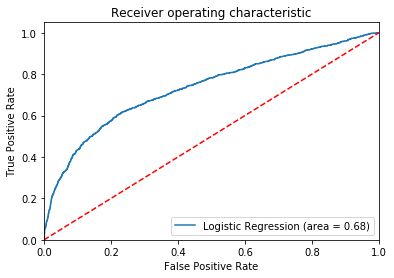

In [16]:
logit_roc_auc = roc_auc_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, logreg_cv.predict_proba(X_test)[:,1])


plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [23]:
def logreg(X, y, cv):
    """
    Creates folds manually, perform 
    Returns an array of validation (recall) scores
    """
    if cv == 'kf':
        cv = KFold(n_splits = 10, shuffle = True, random_state = 4)
    elif cv == 'skf':
        cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 4)
    else:
        cv == None
    
    scores = []
    logreg = LogisticRegression()
    grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
    logreg_cv=GridSearchCV(logreg,grid,cv=10)
    for train_index,test_index in cv.split(X,y):
        X_train,X_test = X.loc[train_index],X.loc[test_index]
        y_train,y_test = y.loc[train_index],y.loc[test_index]

        # Fit the model on the training data
        model_obj = logreg_cv.fit(X_train, y_train)
        # Score the model on the validation data
        score = recall_score(y_test, model_obj.predict(X_test))
        scores.append(score)
    return np.array(scores).mean()


In [18]:
logreg(X, y, kf)

0.6367802118987161

In [19]:
logreg(X, y, skf)

0.636768484824594

In [31]:
def model_classifier(model, X, y, cv):
    """
    Creates folds manually, perform 
    Returns an array of validation (recall) scores
    """
    if cv == 'kf':
        cv = KFold(n_splits = 10, shuffle = True, random_state = 4)
    elif cv == 'skf':
        cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 4)
    else:
        cv == None
    
    scores = []
    
    
    for train_index,test_index in cv.split(X,y):
        X_train,X_test = X.loc[train_index],X.loc[test_index]
        y_train,y_test = y.loc[train_index],y.loc[test_index]

        # Fit the model on the training data
        model_obj = model.fit(X_train, y_train)
        y_pred = model_obj.predict(X_test)
        # Score the model on the validation data
        score = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        scores.append(score)
        mean_score = np.array(scores).mean()
        
    print('Accuracy scores of the model: {:.2f}'.format(mean_score))
    print('\n Classification report of the model')
    print('--------------------------------------')
    print(report)
    
    print('\n Confusion Matrix of the model')
    print('--------------------------------------')
    print(conf_matrix)
    


In [32]:
logreg = LogisticRegression()

In [33]:
model_classifier(logreg, X, y, kf)

Accuracy scores of the model: 0.68

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.73      0.69      3442
           1       0.71      0.64      0.67      3537

    accuracy                           0.68      6979
   macro avg       0.69      0.68      0.68      6979
weighted avg       0.69      0.68      0.68      6979


 Confusion Matrix of the model
--------------------------------------
[[2503  939]
 [1266 2271]]


In [34]:
model_classifier(logreg, X, y, skf)

Accuracy scores of the model: 0.68

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.72      0.69      3489
           1       0.69      0.63      0.66      3490

    accuracy                           0.68      6979
   macro avg       0.68      0.68      0.68      6979
weighted avg       0.68      0.68      0.68      6979


 Confusion Matrix of the model
--------------------------------------
[[2505  984]
 [1278 2212]]


In [35]:
xgb = XGBClassifier()

In [36]:
model_classifier(xgb, X, y, kf)

Accuracy scores of the model: 0.88

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      3442
           1       0.88      0.90      0.89      3537

    accuracy                           0.88      6979
   macro avg       0.89      0.88      0.88      6979
weighted avg       0.89      0.88      0.88      6979


 Confusion Matrix of the model
--------------------------------------
[[2993  449]
 [ 354 3183]]


In [37]:
model_classifier(xgb, X, y, skf)

Accuracy scores of the model: 0.89

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      3489
           1       0.87      0.91      0.89      3490

    accuracy                           0.89      6979
   macro avg       0.89      0.89      0.89      6979
weighted avg       0.89      0.89      0.89      6979


 Confusion Matrix of the model
--------------------------------------
[[3024  465]
 [ 299 3191]]


In [38]:
mlp = MLPClassifier()

In [39]:
model_classifier(mlp, X, y, kf)

Accuracy scores of the model: 0.73

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.81      0.75      3442
           1       0.78      0.65      0.71      3537

    accuracy                           0.73      6979
   macro avg       0.74      0.73      0.73      6979
weighted avg       0.74      0.73      0.73      6979


 Confusion Matrix of the model
--------------------------------------
[[2782  660]
 [1223 2314]]


In [40]:
model_classifier(mlp, X, y, skf)

Accuracy scores of the model: 0.73

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      3489
           1       0.76      0.68      0.72      3490

    accuracy                           0.73      6979
   macro avg       0.73      0.73      0.73      6979
weighted avg       0.73      0.73      0.73      6979


 Confusion Matrix of the model
--------------------------------------
[[2727  762]
 [1112 2378]]


In [43]:
clf = svm.SVC(kernel='linear')

In [44]:
model_classifier(clf, X, y, kf)

Accuracy scores of the model: 0.68

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.74      0.70      3442
           1       0.72      0.62      0.67      3537

    accuracy                           0.68      6979
   macro avg       0.69      0.68      0.68      6979
weighted avg       0.69      0.68      0.68      6979


 Confusion Matrix of the model
--------------------------------------
[[2563  879]
 [1331 2206]]


###### ROC plots 

In [51]:
import os
my_path = os.path.join(os.path.pardir, 'reports','figures')

    
def roc_plot(model, X, y, cv):
    for train_index,test_index in cv.split(X,y):
        X_train,X_test = X.loc[train_index],X.loc[test_index]
        y_train,y_test = y.loc[train_index],y.loc[test_index]
        model_obj = model.fit(X_train, y_train)
        y_pred = model_obj.predict(X_test)
        y_pred_prob = model_obj.predict_proba(X_test)[:,1]
        
        logit_roc_auc = roc_auc_score(y_test, y_pred)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.figure()
    val_model = input("Enter your model name: ")
    plt.plot(fpr, tpr, label= val_model + ' (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    my_fig = val_model + '.png'
    plt.savefig(os.path.join(my_path, my_fig))
    plt.show()

Enter your model name: logisticKFold


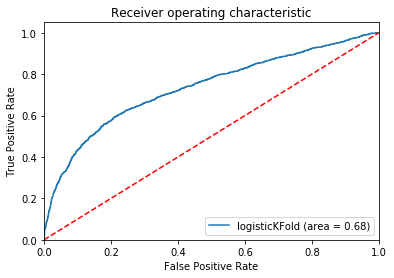

In [52]:
roc_plot(logreg, X, y, kf)

Enter your model name: logisticSKFold


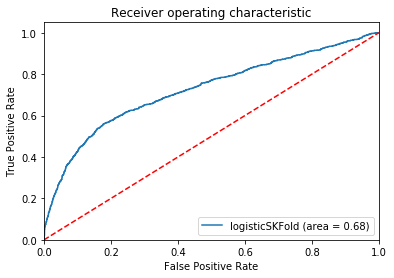

In [53]:
roc_plot(logreg, X, y, skf)

Enter your model name: XGBoostKFold


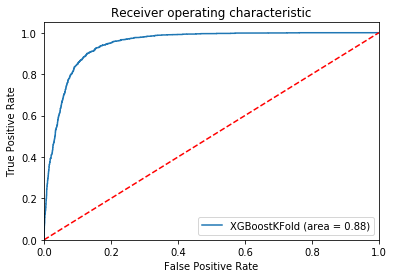

In [54]:
roc_plot(xgb, X, y, kf)

Enter your model name: XGBoostSKFold


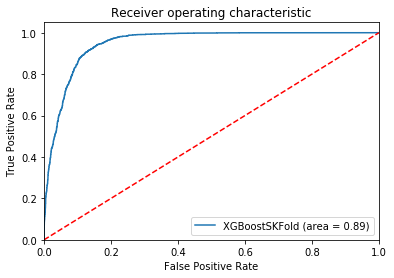

In [55]:
roc_plot(xgb, X, y, skf)

Enter your model name: MLP


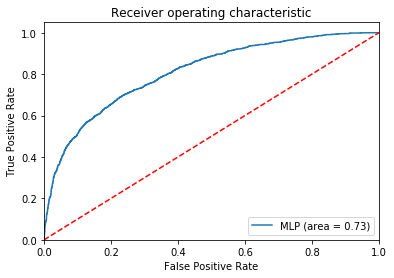

In [50]:
roc_plot(mlp, X, y, kf)